In [43]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn3
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene, read_homer_gene_exp, read_annotated_peaks
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
workingDirectory = '/home/h1bennet/strains_rna/results/K02_Strains_AMLNtoControl_Kupffer_RNA/'
amlnDirectory = '/home/h1bennet/strains/data/RNA/AMLN_30week_kupffer/'
controlDirectory = '/home/h1bennet/strains/data/RNA/control_kupffer/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

if not os.path.isdir('./figures/'):
    os.mkdir('././figures/')

To do this analysis we will pull from the differential analysis performed by Ty at the following location:  

     /home/ttroutman/strainsKupffer/rnaKupfferNASH/
     
Ty re-ran the analysis filtering hepatocyte biased genes that were contaminating some of our samples. These new results are stored at the following locations:
    
    /home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM/rnaDiff_filter_join
    /home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM/rnaQuan/filterT_join.txt
 

In [67]:
diffDir = '/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_ctrl/rnaDiff_filter_join'
rnaQuan = '/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaQuan/rawT.txt'

# Import differential gene files for examination and plotting

Make folder for figures

In [68]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

## Write differential genes to list for metascape

In [69]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [70]:
log2fc = 1
pval = 0.05
gene_list_dict ={}

In [72]:
comps = np.concatenate(
    [np.sort(glob.glob(diffDir+'/aj*vs*aj*scatter.txt')),
     np.sort(glob.glob(diffDir+'/balb*vs*balb*scatter.txt')),
     np.sort(glob.glob(diffDir+'/c57bl6j*vs*c57bl6j*scatter.txt'))])

In [73]:
for i in np.sort(comps):
    print(i)
    # read in gene expression data
    df = pd.read_csv(i,
                     sep='\t',
                     index_col=0)

    # select differential genes
    # df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[2]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))


/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_ctrl/rnaDiff_filter_join/aj_NASH.vs.aj_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_ctrl/rnaDiff_filter_join/aj_control.vs.aj_NASH.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_ctrl/rnaDiff_filter_join/balbcj_NASH.vs.balbcj_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_ctrl/rnaDiff_filter_join/balbcj_control.vs.balbcj_NASH.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_ctrl/rnaDiff_filter_join/c57bl6j_NASH.vs.c57bl6j_control.scatter.txt
/home/ttroutman/strainsKupffer/rnaKupfferNASH/thresholdOutHepatocyteGenes_TPM_NASH_ctrl/rnaDiff_filter_join/c57bl6j_control.vs.c57bl6j_NASH.scatter.txt


In [74]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/cleaned/'+key+'_kupffer_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()

aj_control_up
51 genes
aj_NASH_up
324 genes
balbcj_control_up
19 genes
balbcj_NASH_up
384 genes
c57bl6j_control_up
492 genes
c57bl6j_NASH_up
688 genes


# How many AMLN induced genes are in common

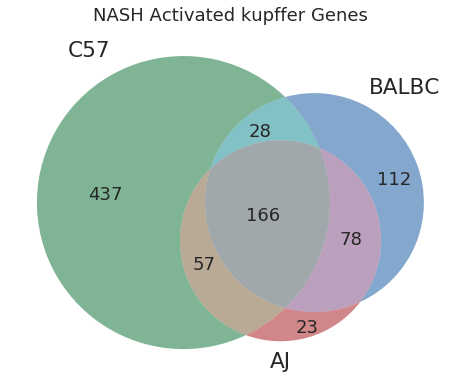

In [75]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(gene_list_dict['c57bl6j_NASH_up']),
               set(gene_list_dict['balbcj_NASH_up']),
               set(gene_list_dict['aj_NASH_up'])],
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('NASH Activated kupffer Genes');

plt.savefig('./figures/venn3_activated_genes.png', bbox_inches='tight')

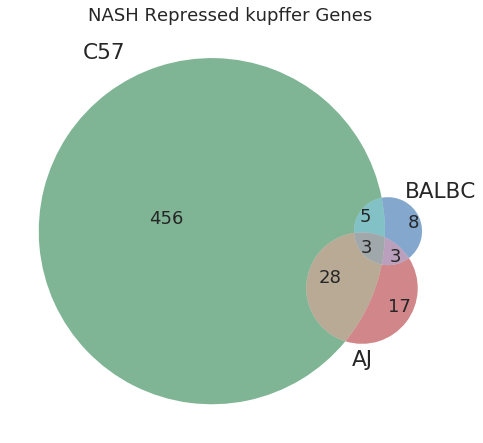

In [76]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(gene_list_dict['c57bl6j_control_up']),
               set(gene_list_dict['balbcj_control_up']),
               set(gene_list_dict['aj_control_up'])],
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('NASH Repressed kupffer Genes');

plt.savefig('./figures/venn3_repressed_genes.png', bbox_inches='tight')

### Pull sets for manual examination

activated genes

In [77]:
all3 = set(gene_list_dict['aj_NASH_up']).intersection(set(gene_list_dict['balbcj_NASH_up']).intersection(gene_list_dict['c57bl6j_NASH_up']))
C57_balbc = set(gene_list_dict['c57bl6j_NASH_up']).intersection(set(gene_list_dict['balbcj_NASH_up']).difference(all3))
C57_aj = set(gene_list_dict['c57bl6j_NASH_up']).intersection(set(gene_list_dict['aj_NASH_up']).difference(all3))
balbc_aj = set(gene_list_dict['balbcj_NASH_up']).intersection(gene_list_dict['aj_NASH_up']).difference(all3)
C57_private = set(gene_list_dict['c57bl6j_NASH_up']).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
balbc_private = set(gene_list_dict['balbcj_NASH_up']).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
aj_private = set(gene_list_dict['aj_NASH_up']).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

In [78]:
genesets = [aj_private, balbc_private, C57_private]
genesetnames = ['aj_private', 'balbc_private', 'c57_private']
for listname, genelist in zip(genesetnames, genesets):
    with open('./gene_lists/cleaned/'+listname+'_kupffer_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in genelist:
            f.write(i+'\n')
        f.close()

### How much of balb set is driven by hepatocyte contamination

We need to try and filter some of the hepatocyte specific genes, our back of the envelope filter will be any gene with hepatocyte expression > 1000 TPM and kupffer cell expression < 100 TPM

In [79]:
control_tpm = pd.read_csv(
    '/gpfs/data01/glasslab/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA/expression/rawT.txt',
    index_col=0,
    sep='\t')

In [80]:
kupffer_avg = control_tpm.loc[:, control_tpm.columns.str.contains('kupffer')].mean(1)
hepatocyte_avg = control_tpm.loc[:, control_tpm.columns.str.contains('hepatocyte')].mean(1)

In [81]:
abs_tpm = (hepatocyte_avg > 500) & (kupffer_avg < 50)
hep_genes = control_tpm.index[abs_tpm].tolist()

In [82]:
ratio = (hepatocyte_avg / kupffer_avg > 10)
hep_genes_ratio = control_tpm.index[ratio].tolist()

In [83]:
print(len(hep_genes))
print(len(balbc_private.intersection(hep_genes)))
print(len(set(gene_list_dict['balbcj_NASH_up']).intersection(hep_genes)))

103
0
0


In [84]:
print(len(set(hep_genes_ratio)))
print(len(set(gene_list_dict['balbcj_NASH_up']).intersection(hep_genes_ratio)))
print(len(balbc_private.intersection(hep_genes_ratio)))

3041
0
0


In [85]:
atac, atac_mat = read_annotated_peaks(
    '/gpfs/data01/glasslab/home/h1bennet/strains/results/01_Strains_AMLN_ATAC/merged_peaks/ann_promoters_atac.txt')

In [86]:
h3k27ac, h3k27ac_mat = read_annotated_peaks(
    '/gpfs/data01/glasslab/home/h1bennet/strains/results/01_Strains_AMLN_H3K27Ac/merged_peaks/ann_promoters_h3k27ac.txt')

In [87]:
h3k27ac_low = (set(h3k27ac.loc[(h3k27ac_mat.mean(1) < 16), 'Gene Name'].dropna().to_list()),
               set(h3k27ac.loc[(h3k27ac_mat.mean(1) < 32), 'Gene Name'].dropna().to_list()))
atac_low = (set(atac.loc[(atac_mat.mean(1) < 16), 'Gene Name'].dropna().to_list()),
            set(atac.loc[(atac_mat.mean(1) < 32), 'Gene Name'].dropna().to_list()))

In [88]:
kc_low = (set(atac_low[0]).intersection(h3k27ac_low[0]),
          set(atac_low[1]).intersection(h3k27ac_low[1]))

In [89]:
print(len(kc_low[1]))
print(len(balbc_private.intersection(kc_low[1])))
print(len(set(gene_list_dict['balbcj_NASH_up']).intersection(kc_low[1])))

11525
44
163


In [90]:
print(len(kc_low[0]))
print(len(balbc_private.intersection(kc_low[0])))
print(len(set(gene_list_dict['balbcj_NASH_up']).intersection(kc_low[0])))

7123
22
55


## Make scatters comparing the genes captured by these methods

Import TPM

In [91]:
tpm = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaQuan/rawT.txt',
                  index_col=0,
                  sep='\t')

Set groups

In [92]:
groups = [[[0,1],[6,7,8,9]],
          [[2,3],[10,11,12]],
          [[4,5],[13,14,15,16]]]

group_labels = [['AJ Control', 'AJ AMLN'],
                ['Balb/cJ Control', 'Balb/cJ AMLN'],
                ['C57BL/6J Control', 'C57BL/6J AMLN']]

### H3K27Ac and ATAC filtering

7123 hepatocyte enriched genes


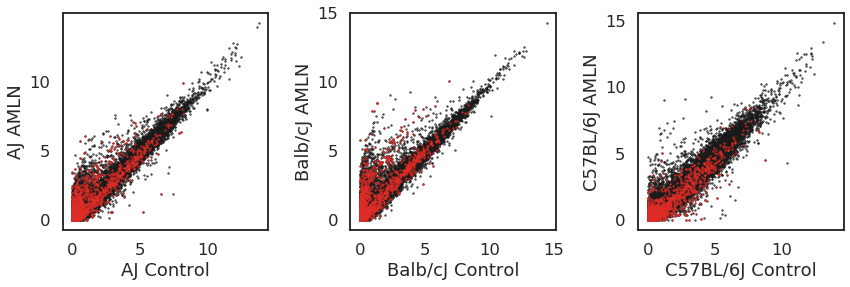

In [93]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
plt.subplots_adjust(wspace=0.4)

# set target gene list
target_set = kc_low[0]
print(len(target_set), 'hepatocyte enriched genes')

for group, label, ax in zip(groups, group_labels, axs.flatten()):
    ax.scatter(np.log2(tpm.iloc[:, group[0]].mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].mean(1)+1),
               c='k',
               s=0.5)
    
    ax.scatter(np.log2(tpm.iloc[:, group[0]].reindex(target_set).mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].reindex(target_set).mean(1)+1),
               c='#de2d26',
               s=0.5)
    
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

11525 hepatocyte enriched genes


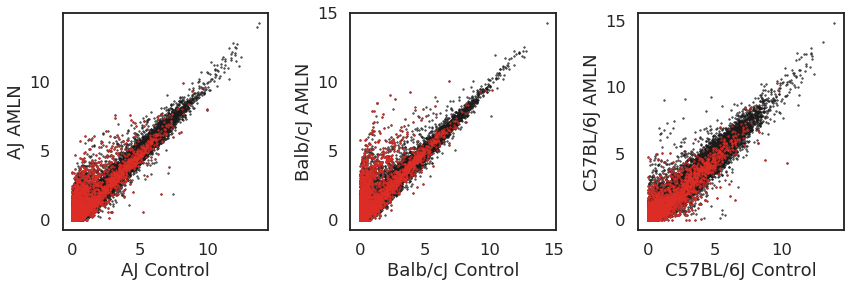

In [94]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
plt.subplots_adjust(wspace=0.4)

# set target gene list
target_set = kc_low[1]
print(len(target_set), 'hepatocyte enriched genes')

for group, label, ax in zip(groups, group_labels, axs.flatten()):
    ax.scatter(np.log2(tpm.iloc[:, group[0]].mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].mean(1)+1),
               c='k',
               s=0.5)
    
    ax.scatter(np.log2(tpm.iloc[:, group[0]].reindex(target_set).mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].reindex(target_set).mean(1)+1),
               c='#de2d26',
               s=0.5)
    
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

Based on these the most reasonable filters appear to be the H3K27Ac + ATAC < 16 filter or the TPM ratio filter. We will try both of these and see how the affect our downstream gene sets (check GO etc etc)

In [95]:
from matplotlib_venn import venn2

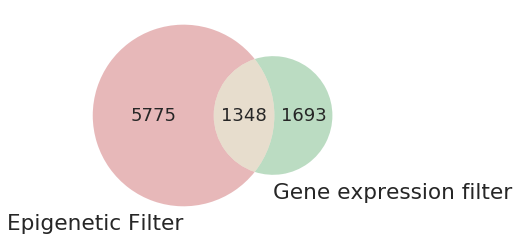

In [96]:
venn2([kc_low[0], set(hep_genes_ratio)],
      set_labels=['Epigenetic Filter',
                  'Gene expression filter'])

### TPM Filtering

expression level

103 hepatocyte enriched genes


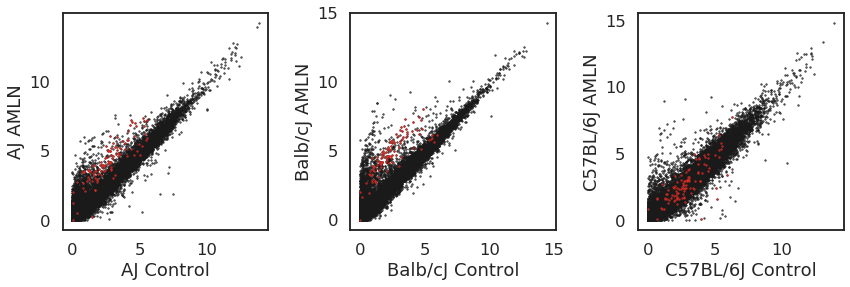

In [33]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
plt.subplots_adjust(wspace=0.4)

# set filtering gene list
target_set = hep_genes
print(len(target_set), 'hepatocyte enriched genes')

for group, label, ax in zip(groups, group_labels, axs.flatten()):
    ax.scatter(np.log2(tpm.iloc[:, group[0]].mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].mean(1)+1),
               c='k',
               s=0.5)
    
    ax.scatter(np.log2(tpm.iloc[:, group[0]].reindex(target_set).mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].reindex(target_set).mean(1)+1),
               c='#de2d26',
               s=0.5)
    
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

Expression ratio

3041 hepatocyte enriched genes


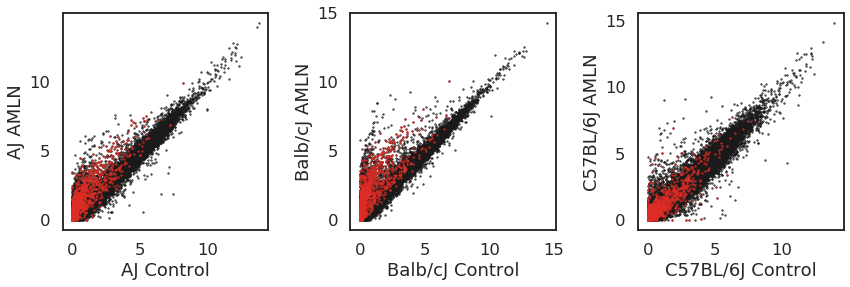

In [34]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
plt.subplots_adjust(wspace=0.4)

# set filtering gene list
target_set = hep_genes_ratio
print(len(target_set), 'hepatocyte enriched genes')

for group, label, ax in zip(groups, group_labels, axs.flatten()):
    ax.scatter(np.log2(tpm.iloc[:, group[0]].mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].mean(1)+1),
               c='k',
               s=0.5)
    
    ax.scatter(np.log2(tpm.iloc[:, group[0]].reindex(target_set).mean(1)+1),
               np.log2(tpm.iloc[:, group[1]].reindex(target_set).mean(1)+1),
               c='#de2d26',
               s=0.5)
    
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

## Write differential genes to list for metascape (filtered)

In [35]:
if not os.path.isdir('./gene_lists/combined/'):
    os.mkdir('./gene_lists/combined/')

In [36]:
log2fc = 1
pval = 0.05
gene_list_dict ={}

In [37]:
comps = np.concatenate(
    [np.sort(glob.glob('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj*vs*aj*scatter.txt')),
     np.sort(glob.glob('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/balb*vs*balb*scatter.txt')),
     np.sort(glob.glob('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/c57bl6j*vs*c57bl6j*scatter.txt'))])

In [38]:
for i in np.sort(comps):
    print(i)
    # read in gene expression data
    df = pd.read_csv(i,
                     sep='\t',
                     index_col=0)
    
    # epigenetic filter
    df_filt_epi = df.loc[~df.index.str.contains('|'.join(kc_low[0])), :]
    
    # tpm filter
    df_filt_tpm = df.loc[~df.index.str.contains('|'.join(hep_genes_ratio)), :]
    
    # select differential genes
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    sig_genes_filt_epi = df_filt_epi.index[
        (df_filt_epi['padj'] < pval) & (df_filt_epi['log2FoldChange'] >= log2fc)].to_list()
    sig_genes_filt_tpm = df_filt_tpm.index[
        (df_filt_tpm['padj'] < pval) & (df_filt_tpm['log2FoldChange'] >= log2fc)].to_list()
    
    # check length:
    print(i.split('.')[2],'up genes')
    print('sig genes: %d\nsig genes (epi filt): %d\nsig genes (tpm filt): %d\n' % (len(sig_genes),
                                                                                   len(sig_genes_filt_epi),
                                                                                   len(sig_genes_filt_tpm)))
    
    # add to dictionary
    gene_list_dict[i.split('.')[2]+'_up'] = list(sig_genes)
    gene_list_dict[i.split('.')[2]+'_up_filt_epi'] = list(sig_genes_filt_epi)
    gene_list_dict[i.split('.')[2]+'_up_filt_tpm'] = list(sig_genes_filt_tpm)    

/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_NASH.vs.aj_control.scatter.txt
aj_control up genes
sig genes: 43
sig genes (epi filt): 25
sig genes (tpm filt): 40

/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/aj_control.vs.aj_NASH.scatter.txt
aj_NASH up genes
sig genes: 239
sig genes (epi filt): 143
sig genes (tpm filt): 205

/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/balbcj_NASH.vs.balbcj_control.scatter.txt
balbcj_control up genes
sig genes: 22
sig genes (epi filt): 10
sig genes (tpm filt): 20

/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/balbcj_control.vs.balbcj_NASH.scatter.txt
balbcj_NASH up genes
sig genes: 475
sig genes (epi filt): 249
sig genes (tpm filt): 296

/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/c57bl6j_NASH.vs.c57bl6j_control.scatter.txt
c57bl6j_control up genes
sig genes: 437
sig genes (epi filt): 270
sig genes (tpm filt): 409

/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaDiff/c57bl6j_control.vs.c57bl6j_NASH.scatter

In [39]:
for genes, lab in zip([hep_genes_ratio, kc_low[0]],
                  ['tpm_ratio_threshold', 'promoter_h3K27ac_atac_threshold']):
    with open('./gene_lists/'+lab+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in genes:
            f.write(i+'\n')
        f.close()

In [40]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_kupffer_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()

aj_control_up
43 genes
aj_control_up_filt_epi
25 genes
aj_control_up_filt_tpm
40 genes
aj_NASH_up
239 genes
aj_NASH_up_filt_epi
143 genes
aj_NASH_up_filt_tpm
205 genes
balbcj_control_up
22 genes
balbcj_control_up_filt_epi
10 genes
balbcj_control_up_filt_tpm
20 genes
balbcj_NASH_up
475 genes
balbcj_NASH_up_filt_epi
249 genes
balbcj_NASH_up_filt_tpm
296 genes
c57bl6j_control_up
437 genes
c57bl6j_control_up_filt_epi
270 genes
c57bl6j_control_up_filt_tpm
409 genes
c57bl6j_NASH_up
588 genes
c57bl6j_NASH_up_filt_epi
379 genes
c57bl6j_NASH_up_filt_tpm
534 genes


save together for metascape

In [41]:
conditions = ['aj_NASH_up',
              'aj_control_up',
              'balbcj_NASH_up',
              'balbcj_control_up',
              'c57bl6j_NASH_up',
              'c57bl6j_control_up']
filters = ['', '_filt_epi', '_filt_tpm']

In [42]:
for cond in conditions:
    genelists = []
    labels = []
    for filt in filters:
        genelists.append(gene_list_dict[cond+filt])
        labels.append(cond+filt)
        
    pd.DataFrame(genelists,
                 index=labels).T.to_csv('./gene_lists/combined/'+cond+'_combined.csv',
                                                            index=False)

In [1]:
all3 = set(gene_list_dict['aj_NASH_up_filt_tpm']).intersection(set(gene_list_dict['balbcj_NASH_up_filt_tpm']).intersection(gene_list_dict['c57bl6j_NASH_up_filt_tpm']))
C57_balbc = set(gene_list_dict['c57bl6j_NASH_up_filt_tpm']).intersection(set(gene_list_dict['balbcj_NASH_up_filt_tpm']).difference(all3))
C57_aj = set(gene_list_dict['c57bl6j_NASH_up_filt_tpm']).intersection(set(gene_list_dict['aj_NASH_up_filt_tpm']).difference(all3))
balbc_aj = set(gene_list_dict['balbcj_NASH_up_filt_tpm']).intersection(gene_list_dict['aj_NASH_up_filt_tpm']).difference(all3)
C57_private = set(gene_list_dict['c57bl6j_NASH_up_filt_tpm']).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
balbc_private = set(gene_list_dict['balbcj_NASH_up_filt_tpm']).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
aj_private = set(gene_list_dict['aj_NASH_up_filt_tpm']).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

NameError: name 'gene_list_dict' is not defined

# Plot single genes using barplot

In [42]:
tpm = pd.read_csv('/home/ttroutman/strainsKupffer/rnaKupfferNASH/rnaQuan/rawT.txt',
                  index_col=0,
                  sep='\t')

In [51]:
groups = [[0,1],
          [6,7,8,9],
          [2,3],
          [10,11,12],
          [4,5],
          [13,14,15,16]]

group_labels = ['AJ Kupffer Control young',
                'AJ Kupffer AMLN 30 weeks',
                'Balb/cJ Kupffer Control young',
                'Balb/cJ Kupffer AMLN 30 weeks',
                'C57BL/6J Kupffer Control young',
                'C57BL/6J Kupffer AMLN 30 weeks']

colors = ['#de2d26',
          '#a50f15',
          '#6baed6',
          '#08519c',
          '#74c476',
          '#006d2c']

In [52]:
legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

[]

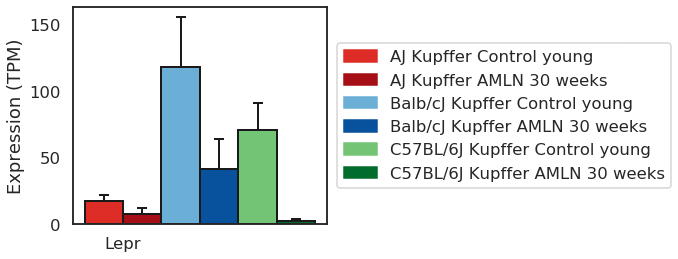

In [53]:
gene = ['Lepr']

fig, axs = plt.subplots(1, 2,
                       figsize=(10, 4))

gene_list_bar_plot(gene,
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.1,
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')

[]

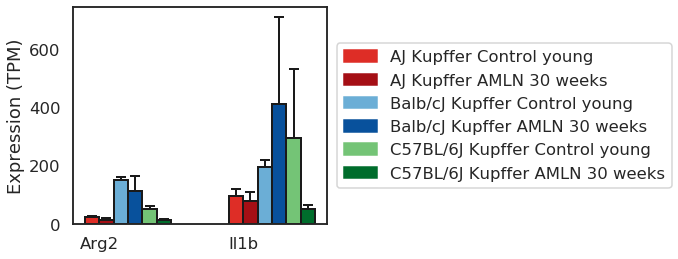

In [45]:
gene = ['Arg2', 'Il1b']

fig, axs = plt.subplots(1, 2,
                       figsize=(10, 4))

gene_list_bar_plot(gene,
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.1,
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')

# plt.savefig('./figures/'+gene+'_tpm_barplot.png', bbox_inches='tight')

In [54]:
groups = [[0,1],
          [2,3],
          [4,5]]

group_labels = ['AJ Kupffer Control young',
                'Balb/cJ Kupffer Control young',
                'C57BL/6J Kupffer Control young']

colors = ['#de2d26',
          '#6baed6',
          '#74c476']

In [55]:
legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

[]

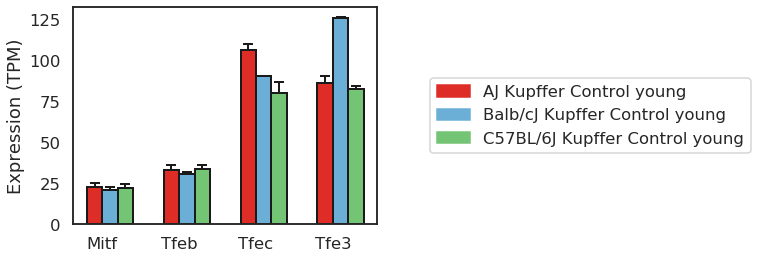

In [56]:
gene = ['Mitf', 'Tfeb', 'Tfec', 'Tfe3']

fig, axs = plt.subplots(1, 2,
                       figsize=(12, 4))

gene_list_bar_plot(gene,
                   tpm,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.2, 
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')